# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator

2022-06-06 08:45:28.647800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 08:45:28.647844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


## Load monthly paths

In [2]:
import importlib
importlib.reload(market_generator)

<module 'market_generator' from '/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/market_generator.py'>

In [3]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=None)

/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/market_generator.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.orig_logsig = np.array([np.diff(np.log(path[::2, 1])) for path in self.windows])


## Plot paths

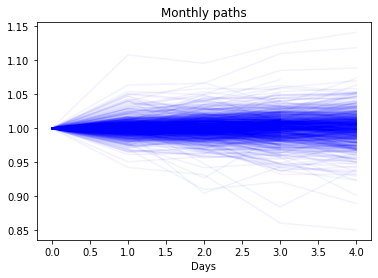

In [4]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)

/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/cvae.py:27: UserWarning: `tf.layers.dense` is deprecated and will be rem

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))

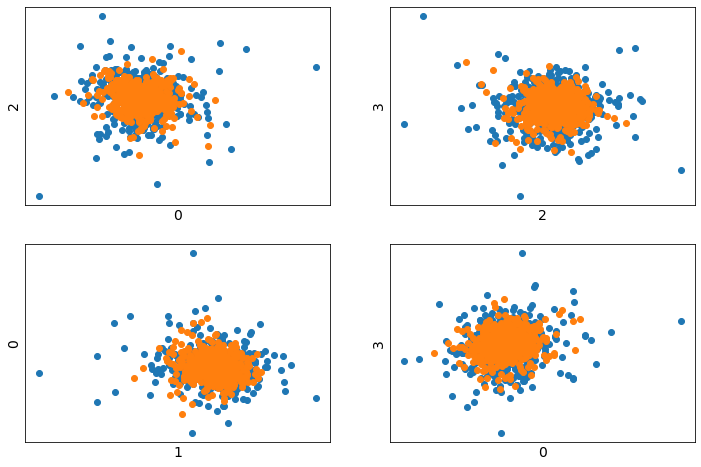

In [7]:
PROJECTIONS = [(0, 2), (2, 3), (1, 0), (0, 3)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(MG.orig_logsig[:, projection[0]], MG.orig_logsig[:, projection[1]],
                label="Real data")
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated")
    plt.xlabel(projection[0], fontsize=14)
    plt.ylabel(projection[1], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

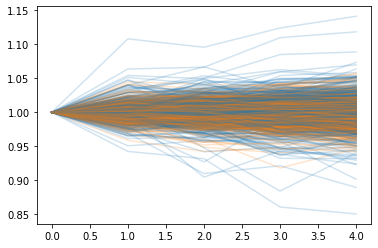

In [8]:
paths_generated = np.exp(MG.orig_logsig.cumsum(axis=1))
paths_orig = np.exp(generated.cumsum(axis=1))
for p1, p2 in zip(paths_generated, paths_orig):
    plt.plot(np.r_[1., p1], "C0", alpha=0.2)
    plt.plot(np.r_[1., p2], "C1", alpha=0.2)
    
    
plt.show()

In [9]:
from utils.leadlag import leadlag
import process_discriminator
import iisignature

order = 4
sigs1 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_generated[:-1])])
sigs2 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_orig)])

100%|██████████| 818/818 [00:00<00:00, 15457.12it/s]


In [10]:
import importlib
importlib.reload(process_discriminator)

<module 'process_discriminator' from '/home/notebook/private/model/latent_model/market_simulator-master/notebooks/../src/process_discriminator.py'>

In [11]:
res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 1:   0%|          | 0/818 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/818 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False
